<h2> II. Programming and critical analysis [8v]
                           
<h4> Consider the parkinsons.csv dataset (available at the course’s webpage), where the goal is
to predict a patient’s score on the Unified Parkinson’s Disease Rating Scale based on various
biomedical measurements.

To answer question 5), average the performance of the models over 10 separate runs. In each
run, use a different 80-20 train-test split by setting a random_state=i, with i=1..10.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('parkinsons.csv')
x = data.drop('target', axis=1)
y = data['target']

<h4>  5)  [2v] Train a Linear Regression model, an MLP Regressor with 2 hidden layers of 10
neurons each and no activation functions, and another MLP Regressor with 2 hidden
layers of 10 neurons each using ReLU activation functions. (Use random_state=0 on the
MLPs, regardless of the run). Plot a boxplot of the test MAE of each model.


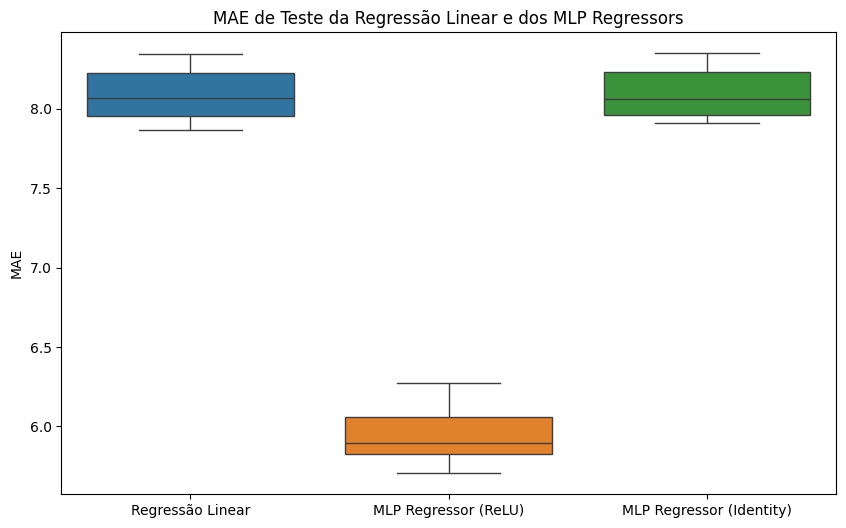

In [2]:
import warnings
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

mlp1_mae_all = []
mlp2_mae_all = []
mae_linear = []

for i in range(1, 11):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=i)

    lin_reg = LinearRegression()
    lin_reg.fit(x_train, y_train)
    y_pred = lin_reg.predict(x_test)
    mae_linear.append(mean_absolute_error(y_test, y_pred))

    mlp1 = MLPRegressor(hidden_layer_sizes=(10, 10), activation= 'relu', random_state=0)
    mlp1.fit(x_train, y_train)
    y_pred = mlp1.predict(x_test)
    mlp1_mae_all.append(mean_absolute_error(y_test, y_pred))

    mlp2 = MLPRegressor(hidden_layer_sizes=(10, 10), activation= 'identity', random_state=0)
    mlp2.fit(x_train,y_train)
    y_pred = mlp2.predict(x_test)
    mlp2_mae_all.append(mean_absolute_error(y_test, y_pred))

mae_data = pd.DataFrame({
    'Regressão Linear': mae_linear,
    'MLP Regressor (ReLU)': mlp1_mae_all,
    'MLP Regressor (Identity)': mlp2_mae_all
})

plt.figure(figsize=(10, 6))
sns.boxplot(data=mae_data)
plt.title('MAE de Teste da Regressão Linear e dos MLP Regressors')
plt.ylabel('MAE')
plt.show()

<h4> 6)  [3v] Compare a Linear Regression with a MLP with no activations, and explain the impact
and the importance of using activation functions in a MLP. Support your reasoning with the
results from the boxplots.


Observando o os resultados do exercicio anterior, vemos que o MLP com ativação ReLU tem um MAE de ~6 enquanto a Regressão linear e o MLP sem ativação têm MAE semelhantes, próximas de ~8. A regressão linear e o MLP sem ativações têm erros muito próximos pois, sem funções de ativação, o comportamento da MLP torna-se muito semelhante ao de uma regressão linear. A ausência de não-linearidade impede o MLP de encontrar padrões de informação mais complexos.

O MAE diminui bastante quando introduzimos uma função de ativação ReLU. O uso de funções de ativação é importante pois introduz não linearidade no modelo permitindo ao mesmo aprender padrões de informação mais complexos e adaptar-se melhor aos dados, diminuindo o erro.

<h4>  7)  [3v] Using a 80-20 train-test split with random_state=0, use a Grid Search to tune the
hyperparameters of an MLP regressor with two hidden layers (size 10 each). The
parameters to search over are: (i) L2 penalty, with the values {0.0001, 0.001, 0.01}; (ii)
learning rate, with the values {0.001, 0.01, 0.1}; and (iii) batch size, with the values
{32, 64, 128}. Plot the test MAE for each combination of hyperparameters, report the
best combination, and discuss the trade-offs between the combinations.


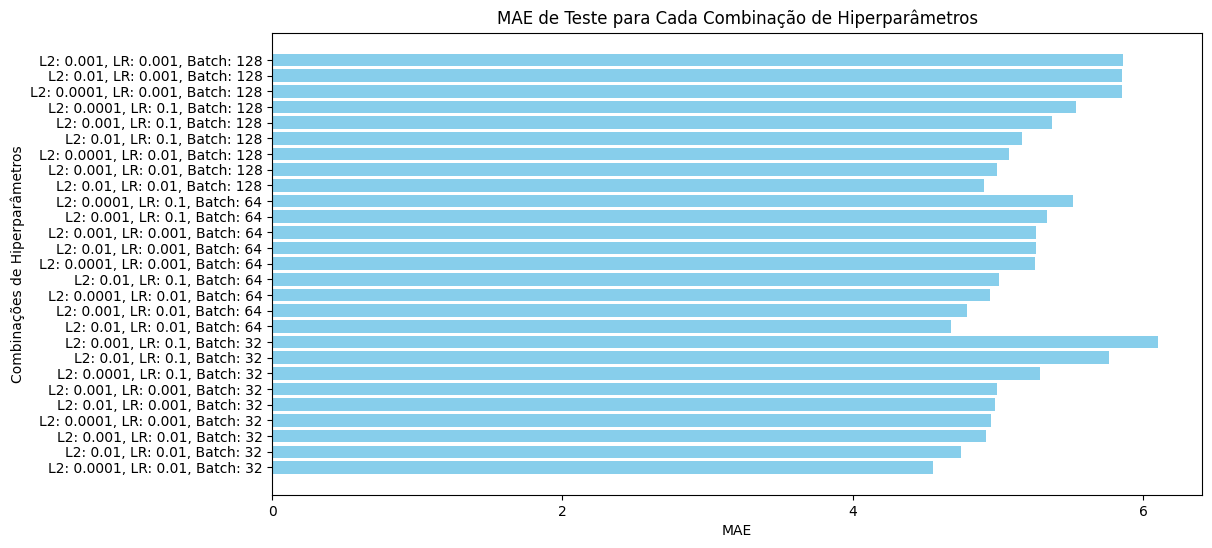

Melhor combinação: {'alpha': 0.0001, 'batch_size': 32, 'learning_rate_init': 0.01}  MAE: 4.555817948029912


In [4]:
from sklearn.model_selection import GridSearchCV
import numpy as np

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'batch_size': [32, 64, 128]
}

mlp = MLPRegressor(hidden_layer_sizes=(10, 10), random_state=0)
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(x_test)
mae = mean_absolute_error(y_test, y_pred)

results = grid_search.cv_results_

param_combinations = [f"L2: {params['alpha']}, LR: {params['learning_rate_init']}, Batch: {params['batch_size']}"
                      for params in results['params']]

mae_scores = -results['mean_test_score']

mae_data = pd.DataFrame({
    'Parameters': param_combinations,
    'Mean Test Score': mae_scores
})

mae_data['Batch Size'] = [int(params.split(', ')[2].split(': ')[1]) for params in mae_data['Parameters']]

mae_data_sorted = mae_data.sort_values(by=['Batch Size', 'Mean Test Score'])

plt.figure(figsize=(12, 6))
plt.barh(mae_data_sorted['Parameters'], mae_data_sorted['Mean Test Score'], color='skyblue')
plt.xlabel('MAE')
plt.ylabel('Combinações de Hiperparâmetros')
plt.title('MAE de Teste para Cada Combinação de Hiperparâmetros')
plt.xticks(np.arange(0, 7, 2))
plt.show()

print(f"Melhor combinação: {grid_search.best_params_}  MAE: {-grid_search.best_score_}")


Trade offs

L2 - penalty : Para valores baixos (0.0001) a regularização dos pesos é baixa e por isso o modelo corre o risco de ficar overfitted aos dados de treino. Aumentando a regularização os pesos mais altos deixam de ter tanto impacto e o modelo torna-se mais flexível, embora corra o risco de underfitting.

Batch size: Para Batchs maiores, as atualizações tornam-se mais estáveis e confiáveis, já que o treino é mais rápido, mas também pode levar a convergência em mínimos locais, o que reduz a capacidade de generalização do modelo.  Em Batchs menores as atualizações são mais frequentes, o que ajuda a escapar aos mínimos locais e melhora a generalização do modelo, mas o treino pode ser mais instável, devido uma maior variância dos dados.

Learning Rate: Para valores mais baixos de LR a convergência dos pesos será mais suave, no entanto também será mais lenta, podendo nunca convergir. Aumentando a LR a convergência será mais errática, com os valores dos pesos a oscilar mais, correndo o risco de ultrapassar os pesos ideias.

A nossa combinação ideal usa o L2 penalty e batch size mais baixos e o learning rate intermédio.